##### Бронников Максим Андреевич
##### М8О-407Б-17

<h1><center> Линейная нейронная сеть. Правило обучения Уидроу-Хоффа </center></h1>

**Целью работы** является исследование свойств линейной нейронной сети и алгоритмов ее
обучения, применение сети в задачах аппроксимации и фильтрации.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

**Вариант №4:** 

Входные сигналы:

$$ \; x = \sin{(-3t^2 + 10t - 5)}, \; t \in [0.5, 4], \: h = 0.01 $$

$$ \; x = \sin{(2t^2 - 6t + 3)}, \; t \in [0, 5], \: h = 0.02 $$

Выходной сигнал:

$$y = \displaystyle\frac{1}{2} \sin{(2 t^2 - 6t - \pi)}$$

In [2]:
def x1_t(t):
    return np.sin(-3*t*t + 10*t - 5)

def x2_t(t):
    return np.sin(2*t*t - 6*t + 3)

def y_t(t):
    return 0.5*np.sin(2*t*t - 6*t - np.pi)

h1 = 0.01
h2 = 0.02

t_lim1 = (0.5, 4)
t_lim2 = (0, 5)

### Описание

Структура *Адаптивного фильтра*: 

Он состоит из **TDL** - слоя, который генерирует на основе предыдущих значений функции $x(t)$ выходной вектор заданной длины, а также **Linear Layer** - слоя, который в качестве функции активации имеет линейную функцию и по своей сути аналогичен алгоритму *линейной регрессии.*

<img src="./img/lin.png">

### Алгоритм обучения

Для обучения линейного слоя используется линейная регрессия:

<img src="./img/algo.png">

### Реализация сети

#### Линейный слой

При обучении добавим к тренировочным данным еденичный столбец для смещения, что позволит рассматривать алгоритм как адаптивный сумматор.

In [3]:
class LinearLayer:
    def __init__(self, steps = 50, lr = 0.0001, stop_err=0.0):
        self.steps = steps
        self.w = None
        self.rate = lr
        self.stop_err = stop_err
    
    def fit(self, X, y):
        # add column for bias and transpose data for comphort operations:
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        y_t = np.array(y)
        
        #init weights:
        if self.w is None:
            self.w = np.random.random((X_t.shape[1], y_t.shape[1]))
        
        # main loop:
        for step in tqdm(range(self.steps)):
            for i in range(X_t.shape[0]):
                e = y_t[i] - X_t[i].dot(self.w) # compute error
                # change weights:
                self.w += self.rate * \
                    X_t[i].reshape(
                        X_t.shape[1], 1
                    ).dot(
                        e.reshape(1, y_t.shape[1])
                    )
            mse = ((y_t - X_t.dot(self.w))**2).mean()
            if mse < self.stop_err:
                break
                
        return self # return trained model
    
    def set_steps(self, steps):
        self.steps = steps
        
    def set_learning_rate(self, rate):
        self.rate = rate
    
    # Predict answers
    def predict(self, X):
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        return X_t.dot(self.w)
    
    
    def display(self):
        ans = "Input(n," + str(self.w.shape[0] - 1) + ")  -->  "
        ans += "Linear_Layer(" + str(self.w.shape[1]) + ")  -->  "
        ans += "Output(n, " + str(self.w.shape[1]) + ") --> "
        return ans
    
    def weights(self):
        return self.w[:-1]
    
    def bias(self):
        return self.w[-1]
        
    
    # RMSE
    def score(self, X, y):
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        y_t = np.array(y)
        return ((y_t - X_t.dot(self.w))**2).mean()**0.5
    
    def __str__(self):
        return "Linear Layer"
    
    def __repr__(self):
        return self.__str__()

#### TDL


Генератор входов по множеству значений.

In [4]:
class TDL:
    def __init__(self, D = 1, pad_zeros=True):
        self.depth = D
        self.padding = pad_zeros
        self.queue = np.zeros(D)
        
    def fit(self, X, Y = None):
        # init train data such as in self.predict method
        if self.padding:
            in_arr = np.append(np.zeros(self.depth - 1), X)
            result = np.zeros((len(X) - 1, self.depth))
            if Y is None:
                Y = X[-len(X) + 1:]
            else:
                Y = Y[-len(X) + 1:]
        else:
            if len(X) < self.depth:
                return None
            in_arr = np.array(X)
            result = np.zeros((len(X) - self.depth, self.depth))
            if Y is None:
                Y = X[-len(X) + self.depth:]
            else:
                Y = Y[-len(X) + self.depth:]
        
        for i in range(in_arr.shape[0] - self.depth):
            result[i] = in_arr[i:i + self.depth]
            
        return result, Y
    
    def tdl_init(self, values):
        if values.shape[0] != self.depth - 1:
            raise ValueError("You should give " + str(self.depth - 1) + " values for init")
        self.queue = np.append(np.zeros(1), np.array(values))
        
        
    def tdl_init_zeros(self):
        self.queue = np.zeros(self.depth)
        
    
    def predict(self, X):
        # init delay line and alloc mem
        in_arr = np.append(self.queue[1:], X)
        result = np.zeros((len(X), self.depth))
        
        # fill memory buffer by values of line
        for i in range(in_arr.shape[0] - self.depth + 1):
            result[i] = in_arr[i:i + self.depth]
        # update queue
        self.queue = in_arr[-self.depth:]
        return result
        
    
    def display(self):
        ans = "TDL(" + str(self.depth) + ") --> "
        return ans
    
    def __str__(self):
        return "TDL"
    
    def __repr__(self):
        return self.__str__()

Фильтратор, состоящий из **TDL** и **Linear Layer**.

In [5]:
class Filtrator:
    def __init__(self, D = 1, pad_zeros = False, steps = 50, l_r=0.001, stop_err=0.0):
        self.tdl = TDL(D, pad_zeros)
        self.linlr = LinearLayer(steps, l_r, stop_err)
        self.tld_initialized = pad_zeros
        self.last_predict = None
        
    def fit(self, X, Y = None):
        X1, Y1 = self.tdl.fit(X, Y)
        Y1 = np.array(Y1).reshape(len(Y1), 1)
        self.linlr.fit(X1, Y1)
        return self
    
    def tdl_init(self, values):
        self.tdl.tdl_init(values)
        self.tld_initialized = True
        
    def tdl_init_zeros(self):
        self.tdl.tdl_init_zeros()
        self.tld_initialized = True
        
    def predict(self, x):
        if not self.tld_initialized:
            raise ValueError("You should init input before predict")
        ans = self.linlr.predict(self.tdl.predict(x)).ravel()
        self.last_predict = ans[-1]
        return ans
            
    def display(self):
        return self.tdl.display() + self.linlr.display()
    
    @staticmethod
    def score_value(Y_t, Y_p):
        return ((Y_t - Y_p)**2).mean()**0.5
        
    def gen_values(self, num, inpt = None):
        if inpt is not None:
            self.last_predict = inpt
        if self.last_predict is None:
            raise ValueError("Last predict doesn`t know. " + 
                             "Please set last predicted value or make prediction.")
        for i in range(num):
            yield self.predict(np.array([self.last_predict]))[0]
    
    def __str__(self):
        return "Adaptive Filtrator"
    
    def __repr__(self):
        return self.__str__()

### Решение

***Задание №1***

Сгенерируем входную последовательность на основе заднного интервала и шага:

In [6]:
T = np.append(np.arange(*t_lim1, h1), t_lim1[1])
X = x1_t(T)

print("Начало множества:", X[:5], "\n" + "Конец множества:", X[-5:])

Начало множества: [-0.68163876 -0.62902627 -0.57385063 -0.51644993 -0.45716058] 
Конец множества: [ 0.12127138 -0.01632866 -0.15421153 -0.28971532 -0.42016704]


Инициализируем модель фильтратора, зададим ему:

1. Глубину задержек $D = 5$.
2. Параметр, указывающий, что не следует использвать погружение временного ряда, а использовать задержки(не делать заполнение входного множеста  нулями).
3. Зададим  скорость обучения для линейного слоя равной $0.01$.
4. Зададим количесво шагов для обучения линейного слоя равными $50$.

После обучим модель для одношагового прогноза и покажем архитектуру полученной сети.

In [7]:
D = 5
steps = 50
learn_rate = 0.01

model = Filtrator(D, False, steps, learn_rate).fit(X)
print(model.display())

100%|██████████| 50/50 [00:01<00:00, 46.55it/s]

TDL(5) --> Input(n,5)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим наше множество на то, чем мы будем инициализировать модель, чем мы будем предсказывать следующий вход и действительный следующий вход модели, который мы будем пытаться предсказать.

In [8]:
X_init = X[:D - 1]
X_test = X[D - 1:-1]

X_ans = X[D:]

Инициализируем модель первыми $D$ значениями множества:

In [9]:
model.tdl_init(X_init)

Сделаем одношаговое предсказание на обучающих данных с помощью обученного фильтра на обучающем множестве:

In [10]:
X_pred = model.predict(X_test)

Результат предсказания на первом входном множестве:

RMSE = 0.018144283736848028


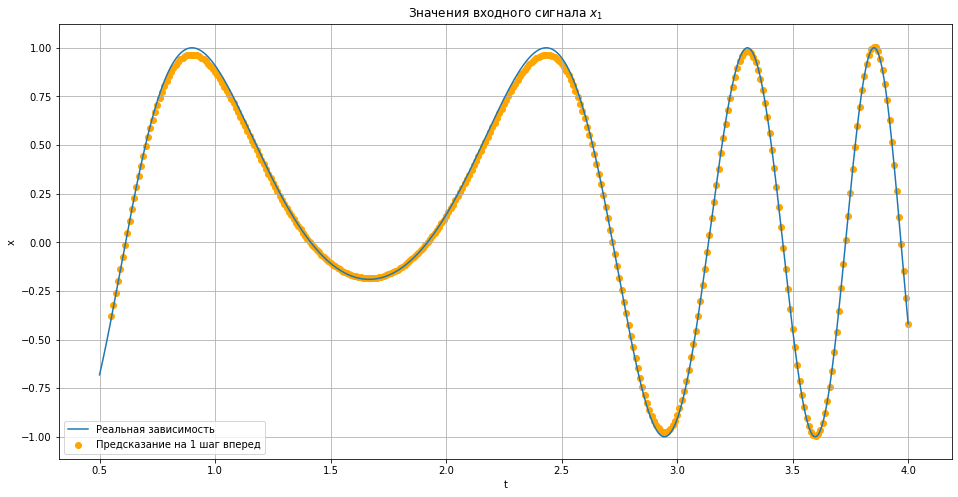

In [11]:
t = np.arange(*t_lim1, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, label="Реальная зависимость")
#plt.scatter(T, X, label="Входные значения")
plt.scatter(T[D:], X_pred, color="orange", label="Предсказание на 1 шаг вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

***Задание №2***

Сгенерируем входную последовательность на основе заднного интервала и шага:

In [12]:
T = np.append(np.arange(*t_lim1, h1), t_lim1[1])
X = x1_t(T)

print("Начало множества:", X[:5], "\n" + "Конец множества:", X[-5:])

Начало множества: [-0.68163876 -0.62902627 -0.57385063 -0.51644993 -0.45716058] 
Конец множества: [ 0.12127138 -0.01632866 -0.15421153 -0.28971532 -0.42016704]


Инициализируем модель фильтратора, зададим ему:

1. Глубину задержек $D = 3$.
2. Параметр, указывающий, что не следует использвать погружение временного ряда, а использовать задержки(не делать заполнение входного множеста  нулями).
3. Зададим  скорость обучения для линейного слоя равной $0.005$, поскольку не известен аналог *maxlinlr* в python.
4. Зададим количесво шагов для обучения линейного слоя равными $600$.
5. Зададим значение ошибки для критерия останова алгоритма обучения равным $10^{-6}$.

После обучим модель для одношагового прогноза и покажем архитектуру полученной сети.

In [13]:
D = 3
steps = 600
learn_rate = 0.005
stop_val = 10e-6

model = Filtrator(D, False, steps, learn_rate, stop_val).fit(X)
print(model.display())

100%|██████████| 600/600 [00:12<00:00, 48.32it/s]

TDL(3) --> Input(n,3)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим наше множество на то, чем мы будем инициализировать модель, чем мы будем предсказывать следующий вход и действительный следующий вход модели, который мы будем пытаться предсказать.

In [14]:
X_init = X[:D - 1]
X_test = X[D - 1:-1]

X_ans = X[D:]

Инициализируем модель первыми $D$ значениями множества:

In [15]:
model.tdl_init(X_init)

Сделаем одношаговое предсказание на обучающих данных с помощью обученного фильтра на обучающем множестве:

In [16]:
X_pred = model.predict(X_test)

Результат предсказания на первом обучающем множестве:

RMSE = 0.006395577550402102


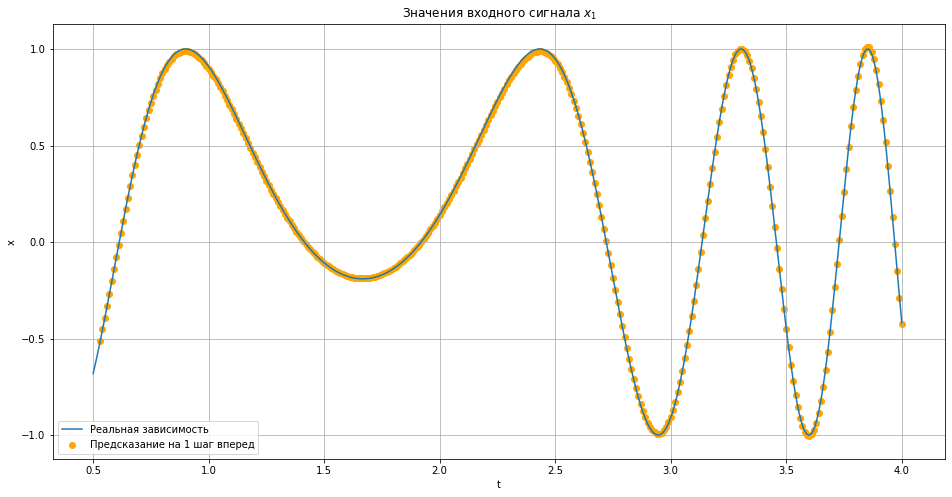

In [17]:
t = np.arange(*t_lim1, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, label="Реальная зависимость")
#plt.scatter(T, X, label="Входные значения")
plt.scatter(T[D:], X_pred, color="orange", label="Предсказание на 1 шаг вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

Сделаем предсказание за пределы обучающего множества на $K=10$ шагов вперед и посмотрим  на результат.

In [18]:
K = 10

X_pred = np.array(list(model.gen_values(K)))

Аргумент $t$ и реальное значени для предсказанных значений:

In [19]:
T_pred = []
for i in range(1, K + 1):
    T_pred.append(t_lim1[1] + i*h1)
    
T_pred = np.array(T_pred)
X_ans = x1_t(T_pred)

Оценим результат многошагового предсказания:

RMSE = 0.18395979236497326


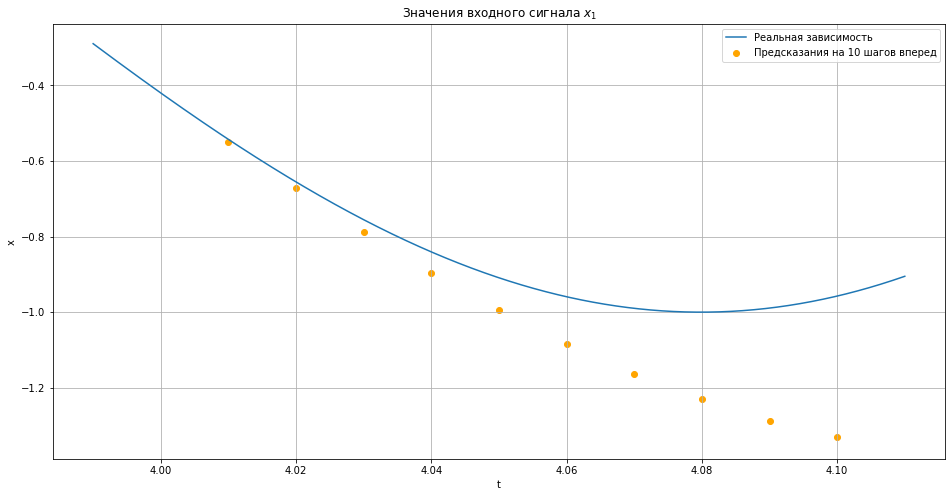

In [20]:
t = np.arange(t_lim1[1] - h1, t_lim1[1] + h1*11, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, label="Реальная зависимость")
#plt.scatter(T, X, label="Входные значения")
plt.scatter(T_pred, X_pred, color="orange", label="Предсказания на 10 шагов вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

***Задание №3***

Сгенерируем входную и выходную последовательности на основе заданного интервала и шага:

In [21]:
T = np.append(np.arange(*t_lim2, h2), t_lim2[1])
X = x2_t(T)
Y = y_t(T)

print("Начало множества:", X[:5], "\n" + "Конец множества:", X[-5:])

Начало множества: [0.14112001 0.25784648 0.36942731 0.47449712 0.57187744] 
Конец множества: [ 0.09819011 -0.17514341 -0.43681182 -0.66660985 -0.8462204 ]


Инициализируем модель фильтратора, зададим ему:

1. Глубину задержек $D =4$.
2. Параметр, указывающий, что следует использвать погружение временного ряда, вместо задержкок(сделать заполнение нулями).
3. Зададим  скорость обучения для линейного слоя равной $0.0025$.
4. Зададим количесво шагов для обучения линейного слоя равными $500$.
5. Зададим значение ошибки для критерия останова алгоритма обучения равным $10^{-6}$.

После обучим модель для одношагового прогноза и покажем архитектуру полученной сети.

Для того, чтобы предсказывать не следующее значение входного сигнала, а выходного, передадим в качестве параметра обучения набор выходных значений.

In [22]:
D = 4
steps = 500
learn_rate = 0.0025
stop_val = 10e-6

model = Filtrator(D, True, steps, learn_rate, stop_val).fit(X, Y)
print(model.display())

100%|██████████| 500/500 [00:07<00:00, 68.93it/s]

TDL(4) --> Input(n,4)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим наше множество на то, чем мы будем инициализировать модель, чем мы будем предсказывать следующий вход и действительный следующий вход модели, который мы будем пытаться предсказать.

In [23]:
X_test = X[:-1]

X_ans = X[1:]
Y_ans = Y[1:]

Инициализируем модель нулевыми значениями:

In [24]:
model.tdl_init_zeros()

Сделаем одношаговое предсказание источника шума с помощью обученного фильтра на обучающем множестве:

In [25]:
Y_pred = model.predict(X_test)

Оценим результат моделирования источника шума:

RMSE = 0.041820303477404716


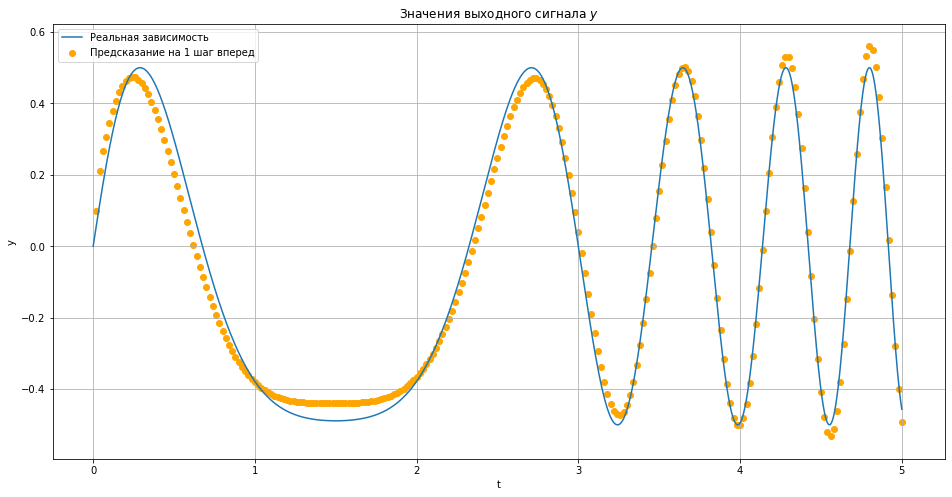

In [26]:
t = np.arange(*t_lim2, 0.0001)
x = y_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, label="Реальная зависимость")
#plt.scatter(T, X, label="Входные значения")
plt.scatter(T[1:], Y_pred, color="orange", label="Предсказание на 1 шаг вперед")
plt.title("Значения выходного сигнала $y$")
plt.xlabel("t")
plt.ylabel("y")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(Y_ans, Y_pred))

<center><h5> Выполнил Бронников Максим </h5></center>
<center><h5> 8.11.2020 </h5></center>